# Part B

'''
PART B:
Thepurpose of this partisto work with a distributed recommender system. To do this, createa recommender system using Apache Spark. Things that were taken into consideration were the efficiency of the systems as well as Spark’s complexity. 

Data input
For part B implementation, the data set is provided to you, download it from Quercus. 
•movies.csv

Implementation
Load Datasetand import required libraries. Create a recommendation system using collaborative filtering approach and answer following questions.

1.[Marks:10] Describe your data. Calculate top 10movies with highest ratings and top 10users who provided highest ratings. Show your code and output.

2.[Marks:10] Split dataset into train and test. Try 2 different combinations for e.g. (60/40, 70/30, 75/25 and 80/20). (Train your model and use collaborative filtering approach on 70percent of your data and test with the other 30percentand so on). Show your codeand output.

3.[Marks:10] Compare  and  evaluate both of your  models with  evaluation metrics  (RMSEor  MSE)  show  your  code  and  print  your  result.Describe which one works better and why?

4.[Marks:30] Now tune  parameters  of  the  algorithm  to  get  the  best  set  of parameters.Explain different  parameters  of  the  algorithmwhich  you  have used for tuning your algorithm. Evaluate all your modelsagain. Show your codewith best valuesand output.

5.[Marks:20] Bonus: Calculatetop 15moviesrecommendations for userid 11 and user id 23.Show your code and output. 
'''

In [0]:
# all data is already integers so no need to cast 
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler # feature engineering components
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml import Pipeline # building the pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

# param evaluation is usually done in serial but you can make it paralelized across our two cores

In [0]:
path = "/FileStore/tables/movies.csv"

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format('csv') \
  .option("inferSchema", True) \
  .option("header", True) \
  .option("sep", ',') \
  .load(path)
  #.option('nanValue', ' ') \
  #.option('nullValue', ' ') \ 
  
#display(df) # function is specific to spark on databricks?

##1.[Marks:10] Describe your data. Calculate top 10movies with highest ratings and top 10users who provided highest ratings. Show your code and output.

In [0]:
# count number of nans in each col. 
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+-------+------+------+
movieId|rating|userId|
+-------+------+------+
 0| 0| 0|
+-------+------+------+

In [0]:
#vec_assembler = VectorAssembler(inputCols=[--,--,--], outputCol='features') not needer here

In [0]:
# from https://runawayhorse001.github.io/LearningApacheSpark/exploration.html
# a more advanced one number summary creating function

import numpy as np
import pandas as pd

def describe_pd(df_in, columns, deciles=False):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    :author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [0]:
# Describe data
df.describe().show() #could have done this but not discriptive enough
describe_pd(df,['movieId','rating','userId'])

+-------+------------------+------------------+------------------+
summary| movieId| rating| userId|
+-------+------------------+------------------+------------------+
 count| 1501| 1501| 1501|
 mean| 49.40572951365756|1.7741505662891406|14.383744170552964|
 stddev|28.937034065088994| 1.187276166124803| 8.591040424293272|
 min| 0| 1| 0|
 max| 99| 5| 29|
+-------+------------------+------------------+------------------+

Out[66]:

,summary,movieId,rating,userId
0,count,1501,1501,1501
1,mean,49.40572951365756,1.7741505662891406,14.383744170552964
2,stddev,28.937034065088994,1.187276166124803,8.591040424293272
3,min,0,1,0
4,max,99,5,29
5,25%,24,1,7
6,50%,50,1,14
7,75%,74,2,22


In [0]:
'''we only really care about the ratings as they are the output we are modeling for.
The distributtion apears skewed as mean and mode are not the same. 
On average the movies are rated just bellow 2/5.
'''

Out[32]: '\nwe only really care about the ratings as they are the output we are modeling for.\nThe distributtion apears skewed as mean and mode are not the same. \nOn average the movies are rated just bellow 2/5.\n'

Out[33]:

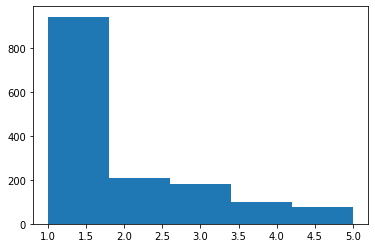

(array([941., 207., 179., 99., 75.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

In [0]:
import matplotlib.pyplot as plt
# Show histogram of the 'C1' column
bins, counts = df.select('rating').rdd.flatMap(lambda x: x).histogram(5)

# This is a bit awkward but I believe this is the correct way to do it 
plt.hist(bins[:-1], bins=bins, weights=counts)

In [0]:
from pyspark.sql.functions import col, skewness, kurtosis
df.select(skewness('rating'),kurtosis('rating')).show()

+------------------+------------------+
 skewness(rating)| kurtosis(rating)|
+------------------+------------------+
1.3966157279688574|0.7918500331672096|
+------------------+------------------+

In [0]:
# data is very skewed
#____________________________________________________________________________
#
# Now onto the top ten movies and top 1 rating users

In [0]:
# top 10 movies based on average ratingss
df.groupBy('movieId').avg('rating').sort('avg(rating)', ascending=False).show(10)

+-------+------------------+
movieId| avg(rating)|
+-------+------------------+
 32|2.9166666666666665|
 90| 2.8125|
 30| 2.5|
 94| 2.473684210526316|
 23| 2.466666666666667|
 49| 2.4375|
 18| 2.4|
 29| 2.4|
 52| 2.357142857142857|
 62| 2.25|
+-------+------------------+
only showing top 10 rows

In [0]:
# top 10 users that on average provide the highest ratings
df.groupBy('userId').avg('rating').sort('avg(rating)', ascending=False).show(10)

+------+------------------+
userId| avg(rating)|
+------+------------------+
 11|2.2857142857142856|
 26| 2.204081632653061|
 22|2.1607142857142856|
 23|2.1346153846153846|
 2|2.0652173913043477|
 17|1.9565217391304348|
 8|1.8979591836734695|
 24|1.8846153846153846|
 12|1.8545454545454545|
 3|1.8333333333333333|
+------+------------------+
only showing top 10 rows

##2.[Marks:10] Split dataset into train and test. Try 2 different combinations for e.g. (60/40, 70/30, 75/25 and 80/20). (Train your model and use collaborative filtering approach on 70percent of your data and test with the other 30percentand so on). Show your code and output.

##3.[Marks:10] Compare  and  evaluate both of your  models with  evaluation metrics  (RMSEor  MSE)  show  your  code  and  print  your  result. Describe which one works better and why?

### I have bundeled the following questions as seen below

In [0]:
# 60/40 training using ALS model default params

(training, test) = df.randomSplit([0.6,0.4])
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 2.056384358987045

In [0]:
# 80/20 training using ALS model default params

(training, test) = df.randomSplit([0.8,0.2])
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.6591046980408197

In [0]:
# significantly lower RMSE on the 80/20 split!
# this means the model is generalizing better and learning more while training when it is exposed to a larger training set. 

## 4.[Marks:30] Now tune  parameters  of  the  algorithm  to  get  the  best  set  of parameters.Explain different  parameters  of  the  algorithmwhich  you  have used for tuning your algorithm. Evaluate all your modelsagain. Show your codewith best valuesand output.

In [0]:
# print the default paramaters from the previous section for reference
print('\ncorresponding (default) parameters:')
{param[0].name: param[1] for param in als.extractParamMap().items()}

corresponding (default) parameters:
Out[43]: {'seed': -1517157561977538513,
 'predictionCol': 'prediction',
 'blockSize': 4096,
 'rank': 10,
 'maxIter': 10,
 'regParam': 0.01,
 'numUserBlocks': 10,
 'numItemBlocks': 10,
 'implicitPrefs': False,
 'alpha': 1.0,
 'userCol': 'userId',
 'itemCol': 'movieId',
 'ratingCol': 'rating',
 'nonnegative': False,
 'checkpointInterval': 10,
 'intermediateStorageLevel': 'MEMORY_AND_DISK',
 'finalStorageLevel': 'MEMORY_AND_DISK',
 'coldStartStrategy': 'drop'}

In [0]:
import numpy as np

(training, test) = df.randomSplit([0.6,0.4])
training.cache()
test.cache()

als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

#Tune model using ParamGridBuilder
parameters=ParamGridBuilder()\
  .addGrid(als.rank, [20, 30])\
  .addGrid(als.regParam, [0.01, 0.1])\
  .addGrid(als.numItemBlocks, [10,20])\
  .addGrid(als.numUserBlocks, [10,20])\
  .build()
#.addGrid(als.maxIter, [5,10])\

#My Observations:
#Rank is the most important param 
#Since ALS converges quite quickly, there is usually no need to change the maxiter parameter from default. 
#max iters can stay low unless regularization influence is high.

#build model evaluator as RMSE
eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

#Build train validation split
trainvs= TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=parameters,
    evaluator=eval,
    parallelism=2)

#Build cross validator
cv= CrossValidator(estimator=als,
    estimatorParamMaps=parameters,
    evaluator=eval,
    numFolds=3,
    parallelism=2)

print('+----------------------------------------------+\nBiased reffers to data trained using TrainValidationSplit \nCross Validated reffers to data trained using cross validation \n+----------------------------------------------+')

# this is where the previously built param grid is searched for thr best params
# Fit model to training data
# training using normal split and cross validation
model_biased = trainvs.fit(training)
model_cv = cv.fit(training)

# Extract the best model params
best_model_biased = model_biased.bestModel
best_model_cv = model_cv.bestModel
#print('+--------------------------------------------+\n')

# Evaluate the model by computing the RMSE on the test data
predictions = model_biased.transform(test)
rmse= eval.evaluate(predictions)
print('biased rmse', rmse)

predictions = model_cv.transform(test)
rmse= eval.evaluate(predictions)
print('cross validated', rmse)

+----------------------------------------------+
Biased reffers to data trained using TrainValidationSplit 
Cross Validated reffers to data trained using cross validation 
+----------------------------------------------+
/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
biased rmse 1.090185867172474
cross validated 1.0887153654715398

In [0]:
'''
60/40 split

Cross validated rmse was slightly lower than the train validation split (biased) training method error. Although the difference is marginal it was expected as the parameters generated via cross validation should be less biased. 
Overall both errors ere close to 1.1 while the error on the naieve implementation was around 2.06. So hyperparameter tuning yeilded some good results. 
'''

In [0]:
print('best TrainValidationSplit (biased) params:', best_model_biased)
print('Rank:', best_model_biased._java_obj.parent().getRank())
# print('MaxIter:', best_model_biased._java_obj.parent().getMaxItler()) hadd to kill this as code was ta
print('RegPrama:', best_model_biased._java_obj.parent().getRegParam())
print('numItemBlocks:', best_model_biased._java_obj.parent().getNumItemBlocks())
print('numUserBlocks:', best_model_biased._java_obj.parent().getNumUserBlocks())
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('best CrossValidated (unbiased) params:', best_model_cv)
print('Rank:', best_model_cv._java_obj.parent().getRank())
# print('MaxIter:', best_model_cv._java_obj.parent().getMaxItler())
print('RegPrama:', best_model_cv._java_obj.parent().getRegParam())
print('numItemBlocks:', best_model_cv._java_obj.parent().getNumItemBlocks())
print('numUserBlocks:', best_model_cv._java_obj.parent().getNumUserBlocks())

best TrainValidationSplit (biased) params: ALSModel: uid=ALS_baeda29a8c3f, rank=30
Rank: 30
RegPrama: 0.1
numItemBlocks: 10
numUserBlocks: 20
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
best CrossValidated (unbiased) params: ALSModel: uid=ALS_baeda29a8c3f, rank=30
Rank: 30
RegPrama: 0.1
numItemBlocks: 10
numUserBlocks: 10

In [0]:
'''
here we see that the paramaters for both training methods only differ in the number of user blocks. 
And the difference is not very significant which explains the very small difference in 
the corresponding RMSE's of both models
'''

In [0]:
# going 80,20 on train test split
import numpy as np

(training, test) = df.randomSplit([0.8,0.2])
training.cache()
test.cache()

als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

#Tune model using ParamGridBuilder
parameters=ParamGridBuilder()\
  .addGrid(als.rank, [20, 30])\
  .addGrid(als.regParam, [0.01, 0.1])\
  .addGrid(als.numItemBlocks, [10,20])\
  .addGrid(als.numUserBlocks, [10,20])\
  .build()
#.addGrid(als.maxIter, [5,10])\

#My Observations:
#Rank is the most important param 
#Since ALS converges quite quickly, there is usually no need to change the maxiter parameter from default. 
#max iters can stay low unless regularization influence is high.

#build model evaluator as RMSE
eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

#Build train validation split
trainvs= TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=parameters,
    evaluator=eval,
    parallelism=2)

#Build cross validator
cv= CrossValidator(estimator=als,
    estimatorParamMaps=parameters,
    evaluator=eval,
    numFolds=3,
    parallelism=2)

print('+----------------------------------------------+\nBiased reffers to data trained using TrainValidationSplit \nCross Validated reffers to data trained using cross validation \n+----------------------------------------------+')

# this is where the previously built param grid is searched for thr best params
# Fit model to training data
# training using normal split and cross validation
model_biased = trainvs.fit(training)
model_cv = cv.fit(training)

# Extract the best model params
best_model_biased = model_biased.bestModel
best_model_cv = model_cv.bestModel
#print('+--------------------------------------------+\n')

# Evaluate the model by computing the RMSE on the test data
predictions = model_biased.transform(test)
rmse= eval.evaluate(predictions)
print('biased rmse', rmse)

predictions = model_cv.transform(test)
rmse= eval.evaluate(predictions)
print('cross validated', rmse)

+----------------------------------------------+
Biased reffers to data trained using TrainValidationSplit 
Cross Validated reffers to data trained using cross validation 
+----------------------------------------------+
biased rmse 0.97802964888379
cross validated 0.97802964888379

In [0]:
'''
80/20 Split
We have a small improvement!
Both training methods are yeilding the same RMSE models which is not to surprising as I had to reduce
my hyper parameter grid complexity for time computation purposes. 

for the 60/40 split we had 
biased rmse 1.090185867172474
cross validated 1.0887153654715398

while for the 80/20 split
biased rmse 0.97802964888379
cross validated 0.97802964888379

As previously mentioned, the larger our training set the more the model can learn and the better it can generalize 
and thats why this error is lower.
'''

In [0]:
print('best TrainValidationSplit (biased) params:', best_model_biased)
print('Rank:', best_model_biased._java_obj.parent().getRank())
# print('MaxIter:', best_model_biased._java_obj.parent().getMaxItler()) hadd to kill this as code was ta
print('RegPrama:', best_model_biased._java_obj.parent().getRegParam())
print('numItemBlocks:', best_model_biased._java_obj.parent().getNumItemBlocks())
print('numUserBlocks:', best_model_biased._java_obj.parent().getNumUserBlocks())
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('best CrossValidated (unbiased) params:', best_model_cv)
print('Rank:', best_model_cv._java_obj.parent().getRank())
# print('MaxIter:', best_model_cv._java_obj.parent().getMaxItler())
print('RegPrama:', best_model_cv._java_obj.parent().getRegParam())
print('numItemBlocks:', best_model_cv._java_obj.parent().getNumItemBlocks())
print('numUserBlocks:', best_model_cv._java_obj.parent().getNumUserBlocks())

best TrainValidationSplit (biased) params: ALSModel: uid=ALS_653ef5c568f8, rank=20
Rank: 20
RegPrama: 0.1
numItemBlocks: 10
numUserBlocks: 10
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
best CrossValidated (unbiased) params: ALSModel: uid=ALS_653ef5c568f8, rank=20
Rank: 20
RegPrama: 0.1
numItemBlocks: 10
numUserBlocks: 10

In [0]:
'''
In terms of our hyperparameters:

previously on the 60/40 split we found that
Rank: 30
RegPrama: 0.1
numItemBlocks: 10
numUserBlocks: 10

yeilded the lowest error. 

for the 80/20 plot we got 

Rank: 20
RegPrama: 0.1
numItemBlocks: 10
numUserBlocks: 10

The only change is our rank (number of latent factors) this has decreased by a third. 

This could mean that the additional training data has meant the model now needs less latent factors generalize
'''

##5.[Marks:20] Bonus: Calculatetop 15moviesrecommendations for userid 11 and user id 23.Show your code and output.

In [0]:
top_15=best_model_cv.recommendForAllUsers(15) # generate top 15 movie recs for all users
display(top_15)

userId,recommendations
10,"List(List(2, 3.2376447), List(92, 3.2321062), List(40, 2.959239), List(81, 2.935212), List(49, 2.8033376), List(89, 2.7255995), List(12, 2.6874645), List(25, 2.66216), List(62, 2.6081908), List(4, 2.4082923), List(0, 2.3052626), List(41, 2.077626), List(91, 1.9497339), List(95, 1.9441298), List(19, 1.9224101))"
0,"List(List(92, 3.284184), List(9, 2.7924862), List(2, 2.6917171), List(62, 2.3812582), List(91, 2.2840772), List(26, 2.204918), List(12, 2.1589327), List(25, 2.1176558), List(49, 2.06134), List(89, 2.0061924), List(77, 1.9658562), List(41, 1.9146563), List(81, 1.9127723), List(40, 1.9033421), List(95, 1.8451796))"
20,"List(List(75, 3.2770188), List(77, 3.1667962), List(90, 3.0697355), List(94, 3.0179195), List(51, 2.9417064), List(62, 2.9276757), List(22, 2.7676852), List(88, 2.7163), List(53, 2.605664), List(74, 2.590242), List(30, 2.5688248), List(98, 2.27167), List(32, 2.243216), List(29, 2.1593068), List(7, 2.1392095))"
1,"List(List(62, 2.9618695), List(77, 2.651899), List(75, 2.4402182), List(90, 2.361423), List(51, 2.3105948), List(85, 2.243665), List(29, 2.212872), List(94, 2.111818), List(88, 2.104052), List(87, 2.0643182), List(53, 2.039624), List(2, 1.9851812), List(92, 1.9719553), List(41, 1.9690001), List(74, 1.9492707))"
11,"List(List(32, 4.805712), List(18, 4.664904), List(30, 4.585123), List(23, 4.511336), List(27, 4.4303083), List(48, 4.3333178), List(79, 4.330261), List(13, 3.6980076), List(81, 3.6268892), List(66, 3.6170578), List(19, 3.5189195), List(38, 3.3015974), List(65, 2.9011571), List(7, 2.8325946), List(75, 2.7875736))"
21,"List(List(29, 4.399909), List(53, 3.9445536), List(52, 3.8344615), List(74, 3.4259396), List(63, 3.416013), List(77, 3.3244338), List(87, 3.2792642), List(62, 3.0458212), List(90, 2.979795), List(85, 2.912758), List(41, 2.8866029), List(2, 2.8853614), List(43, 2.8846014), List(96, 2.8529975), List(76, 2.830716))"
2,"List(List(93, 4.6657715), List(8, 4.5902944), List(39, 4.408862), List(83, 4.305004), List(37, 4.0551944), List(92, 3.645756), List(19, 3.6210966), List(89, 3.602181), List(40, 3.5297153), List(34, 3.484048), List(25, 3.221239), List(81, 3.1446083), List(12, 2.9529755), List(4, 2.9256806), List(66, 2.8101313))"
12,"List(List(17, 4.427969), List(46, 4.359105), List(27, 4.1751866), List(64, 4.142584), List(55, 3.9896376), List(32, 3.919552), List(35, 3.7765822), List(48, 3.6031983), List(50, 3.527145), List(65, 3.466331), List(90, 3.4118788), List(94, 3.4074264), List(10, 3.100275), List(23, 2.9679918), List(20, 2.9232755))"
22,"List(List(75, 4.6451426), List(51, 4.610024), List(74, 4.4027047), List(30, 4.3574524), List(88, 4.3411007), List(22, 4.0622544), List(77, 4.029885), List(90, 3.8343148), List(32, 3.8278966), List(94, 3.7861114), List(62, 3.6326835), List(69, 3.5892708), List(53, 3.5858898), List(98, 3.5703077), List(7, 3.3287053))"
13,"List(List(93, 3.1498394), List(8, 2.8440516), List(53, 2.6817334), List(29, 2.6579115), List(74, 2.6527832), List(18, 2.4107287), List(83, 2.3836153), List(52, 2.3266253), List(37, 2.3006217), List(32, 2.252802), List(72, 2.2348423), List(30, 2.2108738), List(87, 2.1161046), List(39, 2.110603), List(63, 2.0775378))"


In [0]:
top_15.show(5) # what a mess

+------+--------------------+
userId| recommendations|
+------+--------------------+
 10|[[2, 3.2376447], ...|
 0|[[92, 3.284184], ...|
 20|[[75, 3.2770188],...|
 1|[[62, 2.9618695],...|
 11|[[32, 4.805712], ...|
+------+--------------------+
only showing top 5 rows

In [0]:
# user 11s top 15
top_15.filter(top_15.userId == 11).display()

userId,recommendations
11,"List(List(32, 4.805712), List(18, 4.664904), List(30, 4.585123), List(23, 4.511336), List(27, 4.4303083), List(48, 4.3333178), List(79, 4.330261), List(13, 3.6980076), List(81, 3.6268892), List(66, 3.6170578), List(19, 3.5189195), List(38, 3.3015974), List(65, 2.9011571), List(7, 2.8325946), List(75, 2.7875736))"


In [0]:
# user 23s top 15
top_15.filter(top_15.userId == 23).display()

userId,recommendations
23,"List(List(32, 4.7975073), List(55, 4.6112638), List(27, 4.4147396), List(48, 4.35058), List(17, 4.268544), List(46, 4.210397), List(65, 4.051152), List(90, 3.8360083), List(64, 3.8037572), List(30, 3.6707926), List(94, 3.62836), List(50, 3.6247554), List(23, 3.6175675), List(18, 3.6040983), List(13, 3.5818954))"
